# Spray Glider - Interannual variability analysis 

**Purpose**: Code for computing the autocorrelation functions for scalar fields from each spray glider transects.

**Luke Colosi | lcolosi@ucsd.edu**

Force matplotlib plots to display directly within the output cell of the notebook: 

In [1]:
%matplotlib inline


Import python libraries


In [2]:
#--- Build-in Python Functions ---# 
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from netCDF4 import Dataset, num2date
from datetime import datetime
import pandas as pd
import cartopy.crs as ccrs
import sys
import os
import matplotlib 
from geopy.distance import geodesic
import cftime
import matplotlib.dates as mdates
from scipy.interpolate import interp1d
from scipy.integrate import trapezoid
from scipy import stats
import gsw
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.lines as mlines

# Set path to access python functions
sys.path.append('/Users/lukecolosi/Desktop/projects/graduate_research/Gille_lab/AirSeaCoupling/tools/')

#--- Luke's Python Functions ---# 
import cartopy_figs as cart
from autocorr import compute_glider_autocorr, compute_decor_scale
from spectra import spectra_autocov

Set data analysis parameters

In [3]:
# Set processing parameters
option_plot          = 0      # Specifies if supplementary plots are plotted
option_var           = 'density' # Specifies which variable will analyzed. Options include: temp, sal, doxy, chla, density   

# Set time and space parameters
years_d      = ['2007','2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018','2019','2020','2021','2022','2023']    # Specifies the year(s) to analyze
depth_lim    = 10                            # Specifies the bottom depth limit of the depth integration or the single depth for the data record. IMPORTANT: Make sure the single depth is an integer range from 10 to 500 meters in steps of 10 meters
L            = 2                             # Spcifies the spatial interval for data bin averaging (i.e., the spatial resolution)

# Set path to project directory
PATH = "/Users/lukecolosi/Desktop/projects/graduate_research/Gille_lab/AirSeaCoupling"

# Set plotting parameters 
fontsize = 14

Load the autocorrelation intermediate data product 

In [4]:
# Set the path to file
filename_int = PATH + "/data/spray_gliders/CUGN_line_80_intermediate_data_autocorr_" + option_var  + "_depth_lim_" + str(depth_lim) + '_' + years_d[0] + '_to_' + years_d[-1] + ".npz"

# Load data 
data_struct = np.load(filename_int, allow_pickle=True)

# Extract data variables
autocorr_on    = data_struct["autocorr_on"]
autocorr_trans = data_struct["autocorr_trans"]
autocorr_off   = data_struct["autocorr_off"]
autocorr_on_n    = data_struct["autocorr_on_n"]
autocorr_trans_n = data_struct["autocorr_trans_n"]
autocorr_off_n   = data_struct["autocorr_off_n"]
delta_on       = data_struct["delta_on"]
delta_trans    = data_struct["delta_trans"]
delta_off      = data_struct["delta_off"]
delta_on_n       = data_struct["delta_on_n"]
delta_trans_n    = data_struct["delta_trans_n"]
delta_off_n      = data_struct["delta_off_n"]
time           = data_struct["time"]

Compute seasonal autocorrelation functions for the zero lag normalization

In [5]:
# Initialize arrays 
meanAutoCorr_on    = []
meanAutoCorr_trans = []
meanAutoCorr_off   = []
stdmAutoCorr_on    = []
stdmAutoCorr_trans = []
stdmAutoCorr_off   = []
D_on               = []
D_trans            = []
D_off              = []
time_season        = []

# Set the month time array
years = np.array([y.year for y in time])
months = np.array([m.month for m in time])

# Initialize seasons variables
seasons = [[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12]]

# Loop through years 
for year in  np.unique(years):

    # Loop through seasons
    for s in range(0, 4):

        # call season:
        season = seasons[s]

        # Find the indicies for the ith year
        ind_year = years == year

        # Find the indicies for the ith season 
        bool_1 = months == season[0]
        bool_2 = months == season[1]
        bool_3 = months == season[2]
        ind_1 = bool_1 | bool_2
        ind_season = ind_1 | bool_3
        
        # Combine indicies
        ind = ind_year * ind_season

        # Grab autocorrelation functions and their distance scales
        tmp_on    = autocorr_on[ind]
        tmp_trans = autocorr_trans[ind]
        tmp_off   = autocorr_off[ind]
        tmpcor_on    = delta_on[ind]
        tmpcor_trans = delta_trans[ind]
        tmpcor_off   = delta_off[ind]
        tmp_time     = time[ind] 

        # Determine the maximum length of the autocorrelation function
        max_length_on    = max([len(a) for a in tmp_on])
        max_length_trans = max([len(a) for a in tmp_trans])
        max_length_off   = max([len(a) for a in tmp_off])

        # Initailize array 
        tmp_on_array    = np.full((len(tmp_on),max_length_on), np.nan)
        tmp_trans_array = np.full((len(tmp_trans),max_length_trans), np.nan)
        tmp_off_array   = np.full((len(tmp_off),max_length_off), np.nan)

        #--- On-Shelf ---# 
        # Loop through autocorrelation functions
        for i in range(0,len(tmp_on)):

            # Pad the ith autocorrelation functions with NaNs and save into an array 
            tmp_on_array[i,:] = np.pad(tmp_on[i], (0, max_length_on - len(tmp_on[i])), constant_values=np.nan)

        #--- Shelf Break ---# 
        # Loop through autocorrelation functions
        for i in range(0,len(tmp_trans)):

            # Pad the ith autocorrelation functions with NaNs and save into an array 
            tmp_trans_array[i,:] = np.pad(tmp_trans[i], (0, max_length_trans - len(tmp_trans[i])), constant_values=np.nan)

        #--- Off-Shelf ---# 
        # Loop through autocorrelation functions
        for i in range(0,len(tmp_off)):

            # Pad the ith autocorrelation functions with NaNs and save into an array 
            tmp_off_array[i,:] = np.pad(tmp_off[i], (0, max_length_off - len(tmp_off[i])), constant_values=np.nan)

        # Compute the mean autocorrelation function 
        meanAutoCorr_on.append(np.nanmean(tmp_on_array, axis=0))
        meanAutoCorr_trans.append(np.nanmean(tmp_trans_array, axis=0))
        meanAutoCorr_off.append(np.nanmean(tmp_off_array, axis=0))

        # Compute the standard deviation and the number of samples 
        stdAutoCorr_on    = np.nanstd(tmp_on_array, axis=0, ddof=1)
        stdAutoCorr_trans = np.nanstd(tmp_trans_array, axis=0, ddof=1)
        stdAutoCorr_off   = np.nanstd(tmp_off_array, axis=0, ddof=1)
        nAutoCorr_on    = np.count_nonzero(~np.isnan(tmp_on_array), axis=0)
        nAutoCorr_trans = np.count_nonzero(~np.isnan(tmp_trans_array), axis=0)
        nAutoCorr_off   = np.count_nonzero(~np.isnan(tmp_off_array), axis=0)

        # Compute the standard error of the mean (assuming that each data point is an independent observations)
        stdmAutoCorr_on.append(stdAutoCorr_on/np.sqrt(nAutoCorr_on))
        stdmAutoCorr_trans.append(stdAutoCorr_trans/np.sqrt(nAutoCorr_trans))
        stdmAutoCorr_off.append(stdAutoCorr_off/np.sqrt(nAutoCorr_off))

        # Set the distance scale of the mean autocorrelation functions
        longest_index = np.argmax([len(a) for a in tmpcor_on])
        D_on.append(tmpcor_on[longest_index])
        longest_index = np.argmax([len(a) for a in tmpcor_trans])
        D_trans.append(tmpcor_trans[longest_index])
        longest_index = np.argmax([len(a) for a in tmpcor_off])
        D_off.append(tmpcor_off[longest_index])

        # Compute the mean time step of the season 
        timestamps = [dt.timestamp() for dt in tmp_time] # Convert to timestamps
        mean_timestamp = np.nansum(timestamps) / np.count_nonzero(~np.isnan(timestamps)) # Compute mean timestamp
        mean_datetime = datetime.fromtimestamp(mean_timestamp) # Convert back to datetime
        time_season.append(mean_datetime)

# Convert time_month to an array
time_season = np.array(time_season)

/var/folders/2q/rg93ky5n09l14670ynhs0cgh0000gn/T/ipykernel_59736/3114209764.py:83: RuntimeWarning: Mean of empty slice
  meanAutoCorr_on.append(np.nanmean(tmp_on_array, axis=0))
/Users/lukecolosi/opt/anaconda3/envs/airsea_coupling/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/2q/rg93ky5n09l14670ynhs0cgh0000gn/T/ipykernel_59736/3114209764.py:84: RuntimeWarning: Mean of empty slice
  meanAutoCorr_trans.append(np.nanmean(tmp_trans_array, axis=0))
/var/folders/2q/rg93ky5n09l14670ynhs0cgh0000gn/T/ipykernel_59736/3114209764.py:85: RuntimeWarning: Mean of empty slice
  meanAutoCorr_off.append(np.nanmean(tmp_off_array, axis=0))


Compute seasonal autocorrelation functions for the first lag normalization

In [6]:
# Initialize arrays 
meanAutoCorr_on_n    = []
meanAutoCorr_trans_n = []
meanAutoCorr_off_n   = []
stdmAutoCorr_on_n    = []
stdmAutoCorr_trans_n = []
stdmAutoCorr_off_n   = []
D_on_n               = []
D_trans_n            = []
D_off_n              = []
time_season        = []

# Set the month time array
years = np.array([y.year for y in time])
months = np.array([m.month for m in time])

# Initialize seasons variables
seasons = [[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12]]

# Loop through years 
for year in  np.unique(years):

    # Loop through seasons
    for s in range(0, 4):

        # call season:
        season = seasons[s]

        # Find the indicies for the ith year
        ind_year = years == year

        # Find the indicies for the ith season 
        bool_1 = months == season[0]
        bool_2 = months == season[1]
        bool_3 = months == season[2]
        ind_1 = bool_1 | bool_2
        ind_season = ind_1 | bool_3
        
        # Combine indicies
        ind = ind_year * ind_season

        # Grab autocorrelation functions and their distance scales
        tmp_on    = autocorr_on_n[ind]
        tmp_trans = autocorr_trans_n[ind]
        tmp_off   = autocorr_off_n[ind]
        tmpcor_on    = delta_on_n[ind]
        tmpcor_trans = delta_trans_n[ind]
        tmpcor_off   = delta_off_n[ind]
        tmp_time     = time[ind] 

        # Determine the maximum length of the autocorrelation function
        max_length_on    = max([len(a) for a in tmp_on])
        max_length_trans = max([len(a) for a in tmp_trans])
        max_length_off   = max([len(a) for a in tmp_off])

        # Initailize array 
        tmp_on_array    = np.full((len(tmp_on),max_length_on), np.nan)
        tmp_trans_array = np.full((len(tmp_trans),max_length_trans), np.nan)
        tmp_off_array   = np.full((len(tmp_off),max_length_off), np.nan)

        #--- On-Shelf ---# 
        # Loop through autocorrelation functions
        for i in range(0,len(tmp_on)):

            # Pad the ith autocorrelation functions with NaNs and save into an array 
            tmp_on_array[i,:] = np.pad(tmp_on[i], (0, max_length_on - len(tmp_on[i])), constant_values=np.nan)

        #--- Shelf Break ---# 
        # Loop through autocorrelation functions
        for i in range(0,len(tmp_trans)):

            # Pad the ith autocorrelation functions with NaNs and save into an array 
            tmp_trans_array[i,:] = np.pad(tmp_trans[i], (0, max_length_trans - len(tmp_trans[i])), constant_values=np.nan)

        #--- Off-Shelf ---# 
        # Loop through autocorrelation functions
        for i in range(0,len(tmp_off)):

            # Pad the ith autocorrelation functions with NaNs and save into an array 
            tmp_off_array[i,:] = np.pad(tmp_off[i], (0, max_length_off - len(tmp_off[i])), constant_values=np.nan)

        # Compute the mean autocorrelation function 
        meanAutoCorr_on_n.append(np.nanmean(tmp_on_array, axis=0))
        meanAutoCorr_trans_n.append(np.nanmean(tmp_trans_array, axis=0))
        meanAutoCorr_off_n.append(np.nanmean(tmp_off_array, axis=0))

        # Compute the standard deviation and the number of samples 
        stdAutoCorr_on    = np.nanstd(tmp_on_array, axis=0, ddof=1)
        stdAutoCorr_trans = np.nanstd(tmp_trans_array, axis=0, ddof=1)
        stdAutoCorr_off   = np.nanstd(tmp_off_array, axis=0, ddof=1)
        nAutoCorr_on    = np.count_nonzero(~np.isnan(tmp_on_array), axis=0)
        nAutoCorr_trans = np.count_nonzero(~np.isnan(tmp_trans_array), axis=0)
        nAutoCorr_off   = np.count_nonzero(~np.isnan(tmp_off_array), axis=0)

        # Compute the standard error of the mean (assuming that each data point is an independent observations)
        stdmAutoCorr_on_n.append(stdAutoCorr_on/np.sqrt(nAutoCorr_on))
        stdmAutoCorr_trans_n.append(stdAutoCorr_trans/np.sqrt(nAutoCorr_trans))
        stdmAutoCorr_off_n.append(stdAutoCorr_off/np.sqrt(nAutoCorr_off))

        # Set the distance scale of the mean autocorrelation functions
        longest_index = np.argmax([len(a) for a in tmpcor_on])
        D_on_n.append(tmpcor_on[longest_index])
        longest_index = np.argmax([len(a) for a in tmpcor_trans])
        D_trans_n.append(tmpcor_trans[longest_index])
        longest_index = np.argmax([len(a) for a in tmpcor_off])
        D_off_n.append(tmpcor_off[longest_index])

        # Compute the mean time step of the season 
        timestamps = [dt.timestamp() for dt in tmp_time] # Convert to timestamps
        mean_timestamp = np.nansum(timestamps) / np.count_nonzero(~np.isnan(timestamps)) # Compute mean timestamp
        mean_datetime = datetime.fromtimestamp(mean_timestamp) # Convert back to datetime
        time_season.append(mean_datetime)

# Convert time_month to an array
time_season = np.array(time_season)

/var/folders/2q/rg93ky5n09l14670ynhs0cgh0000gn/T/ipykernel_59736/2943090465.py:83: RuntimeWarning: Mean of empty slice
  meanAutoCorr_on_n.append(np.nanmean(tmp_on_array, axis=0))
/var/folders/2q/rg93ky5n09l14670ynhs0cgh0000gn/T/ipykernel_59736/2943090465.py:84: RuntimeWarning: Mean of empty slice
  meanAutoCorr_trans_n.append(np.nanmean(tmp_trans_array, axis=0))
/var/folders/2q/rg93ky5n09l14670ynhs0cgh0000gn/T/ipykernel_59736/2943090465.py:85: RuntimeWarning: Mean of empty slice
  meanAutoCorr_off_n.append(np.nanmean(tmp_off_array, axis=0))


Compute the decorrelation scale and its uncertainty 

In [7]:
#--- Off-shelf ---# 

# Initialize array
L_on = np.zeros(len(time_season))
L_on_ustd = np.zeros(len(time_season))
L_on_lstd = np.zeros(len(time_season))

# Loop through seasons
for m in range(0, len(time_season)):

    # Compute the decorrelation scale 
    L_on[m] = compute_decor_scale(meanAutoCorr_on[m],D_on[m],L,0)

    # Estimate the decorrelation scale's uncertainty by perturbing the autocorrelation function by 1 standard deviation
    L_on_ustd[m] = compute_decor_scale(meanAutoCorr_on[m] + stdmAutoCorr_on[m],D_on[m],L,0)
    L_on_lstd[m] = compute_decor_scale(meanAutoCorr_on[m] - stdmAutoCorr_on[m],D_on[m],L,0)

#--- Shelf-break ---#  

# Initialize array
L_trans = np.zeros(len(time_season))
L_trans_ustd = np.zeros(len(time_season))
L_trans_lstd = np.zeros(len(time_season))

# Loop through months
for m in range(0, len(time_season)):

    # Compute the decorrelation scale 
    L_trans[m] = compute_decor_scale(meanAutoCorr_trans[m],D_trans[m],L,0)

    # Estimate the decorrelation scale's uncertainty by perturbing the autocorrelation function by 1 standard deviation
    L_trans_ustd[m] = compute_decor_scale(meanAutoCorr_trans[m] + stdmAutoCorr_trans[m],D_trans[m],L,0)
    L_trans_lstd[m] = compute_decor_scale(meanAutoCorr_trans[m] - stdmAutoCorr_trans[m],D_trans[m],L,0)

#--- Off-shelf ---# 

# Initialize array
L_off = np.zeros(len(time_season))
L_off_ustd = np.zeros(len(time_season))
L_off_lstd = np.zeros(len(time_season))

# Loop through months
for m in range(0, len(time_season)):

    # Compute the decorrelation scale 
    L_off[m] = compute_decor_scale(meanAutoCorr_off[m],D_off[m],L,0)

    # Estimate the decorrelation scale's uncertainty by perturbing the autocorrelation function by 1 standard deviation
    L_off_ustd[m] = compute_decor_scale(meanAutoCorr_off[m] + stdmAutoCorr_off[m],D_off[m],L,0)
    L_off_lstd[m] = compute_decor_scale(meanAutoCorr_off[m] - stdmAutoCorr_off[m],D_off[m],L,0)

Pad the mean autocorrelation functions and set the distance scale coordinate

In [8]:
# Determine the maximum length of the autocorrelation function
max_length_on    = max([len(a) for a in meanAutoCorr_on])
max_length_trans = max([len(a) for a in meanAutoCorr_trans])
max_length_off   = max([len(a) for a in meanAutoCorr_off])

# Initailize array 
meanAutoCorr_on_array    = np.full((len(meanAutoCorr_on),max_length_on), np.nan)
meanAutoCorr_trans_array = np.full((len(meanAutoCorr_trans),max_length_trans), np.nan)
meanAutoCorr_off_array   = np.full((len(meanAutoCorr_off),max_length_off), np.nan)

#--- On-Shelf ---# 
# Loop through autocorrelation functions
for i in range(0,len(meanAutoCorr_on)):

    # Pad the ith autocorrelation functions with NaNs and save into an array 
    meanAutoCorr_on_array[i,:] = np.pad(meanAutoCorr_on[i], (0, max_length_on - len(meanAutoCorr_on[i])), constant_values=np.nan)

#--- Shelf Break ---# 
# Loop through autocorrelation functions
for i in range(0,len(meanAutoCorr_trans)):

    # Pad the ith autocorrelation functions with NaNs and save into an array 
    meanAutoCorr_trans_array[i,:] = np.pad(meanAutoCorr_trans[i], (0, max_length_trans - len(meanAutoCorr_trans[i])), constant_values=np.nan)

#--- Off-Shelf ---# 
# Loop through autocorrelation functions
for i in range(0,len(meanAutoCorr_off)):

    # Pad the ith autocorrelation functions with NaNs and save into an array 
    meanAutoCorr_off_array[i,:] = np.pad(meanAutoCorr_off[i], (0, max_length_off - len(meanAutoCorr_off[i])), constant_values=np.nan)

# Set the distance scale of the mean autocorrelation functions
longest_index = np.argmax([len(a) for a in D_on])
Delta_on = D_on[longest_index]
longest_index = np.argmax([len(a) for a in D_trans])
Delta_trans = D_trans[longest_index]
longest_index = np.argmax([len(a) for a in D_off])
Delta_off = D_off[longest_index]

Plot the mean autocorrelation functions

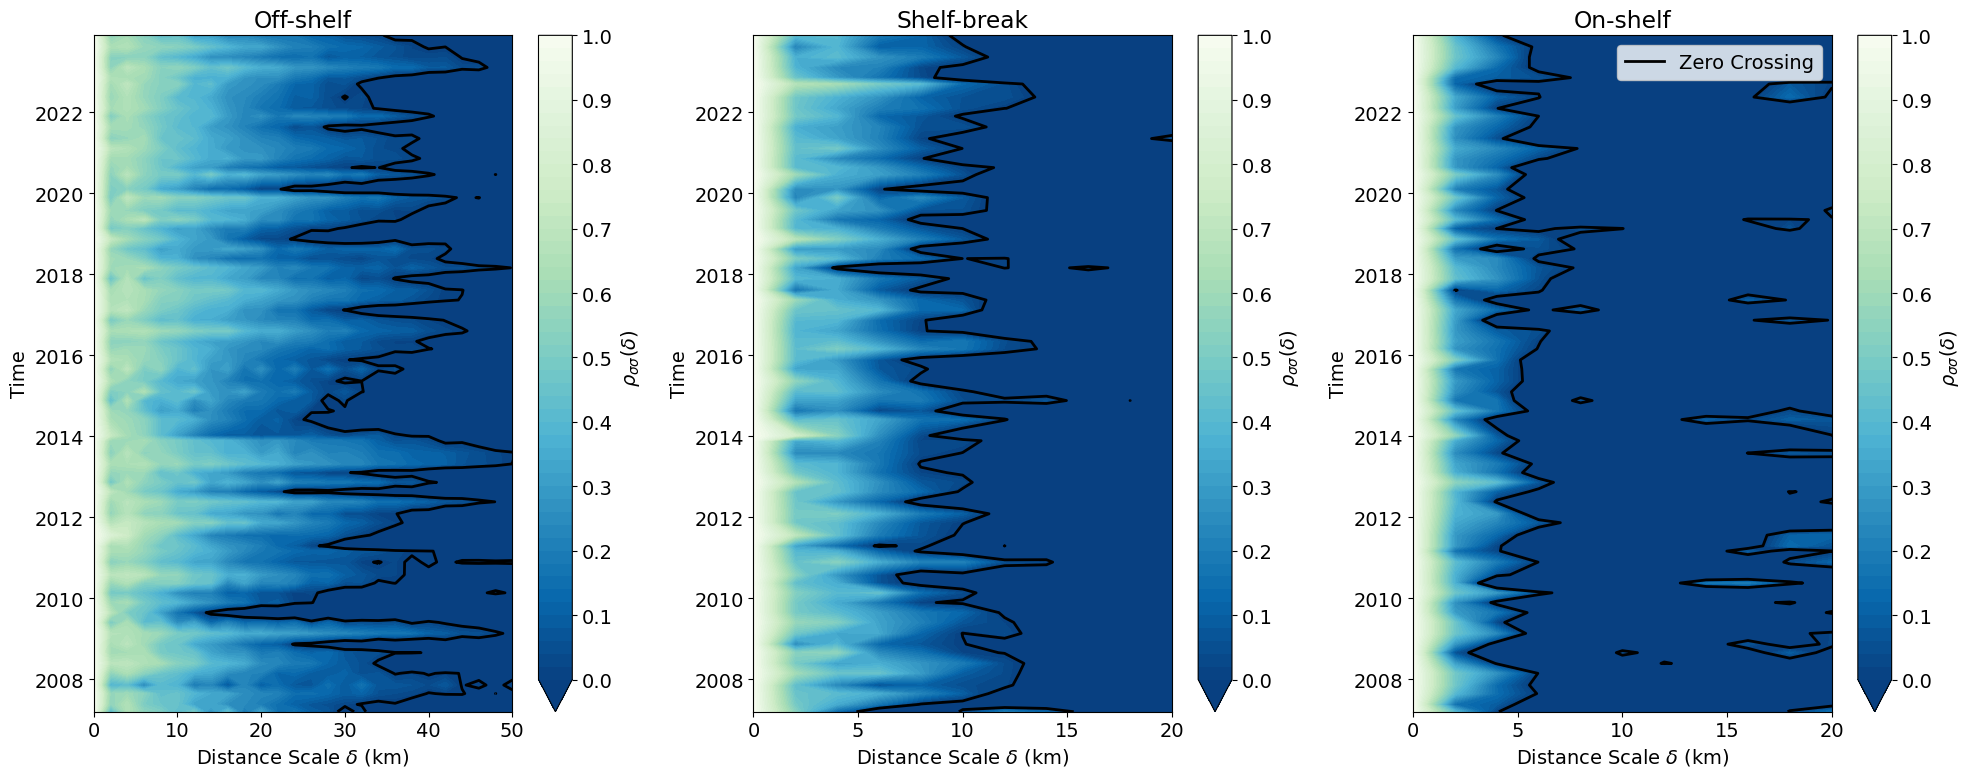

In [9]:
# Set the fontsize
plt.rcParams.update({'font.size': fontsize})

# Set plotting parameters
if option_var == 'temp':
    ylabel = r'$\rho_{TT} (\delta)$'
elif option_var == 'sal':
    ylabel = r'$\rho_{SS} (\delta)$'
elif option_var == 'doxy':
    ylabel = r'$\rho_{OO} (\delta)$'
elif option_var == 'chla':
    ylabel = r'$\rho_{CC} (\delta)$'
elif option_var == 'density': 
    ylabel = r'$\rho_{\sigma\sigma} (\delta)$'

# Set colormap and levels
cmap = plt.cm.GnBu_r
levels=np.arange(0,1+0.02,0.02)

# Create the figure
fig = plt.figure(figsize=(20, 8))

#--- Subplot #1 ---# 
ax1 = fig.add_subplot(131)

# Create meshgrid and zeros surface 
D, T = np.meshgrid(Delta_off, time_season)  

# Plot autocorrelation surface
contour = ax1.contourf(D,T,meanAutoCorr_off_array,levels=levels,cmap=cmap,extend='min')

# Plot and label the zero contour 
zero_contour = plt.contour(D,T,meanAutoCorr_off_array, levels=[0], colors='black', linewidths=2)

# Set figure attributes
ax1.set_title('Off-shelf')
ax1.set_xlabel(r'Distance Scale $\delta$ (km)')
ax1.set_ylabel('Time')
#ax1.set_yticks(np.arange(1,13),months)
ax1.set_xlim(0,50)

# Set color bar
cbar = fig.colorbar(contour,extend='min')
cbar.set_ticks(np.arange(0,1+0.1,0.1)) 
cbar.set_label(ylabel)
contour.set_clim(0,1)

#--- Subplot #2 ---# 
ax2 = fig.add_subplot(132)

# Create meshgrid and zeros surface 
D, T = np.meshgrid(Delta_trans, time_season)  

# Plot autocorrelation surface
contour = ax2.contourf(D,T,meanAutoCorr_trans_array,levels=levels,cmap=cmap,extend='min')

# Plot and label the zero contour 
zero_contour = plt.contour(D,T,meanAutoCorr_trans_array, levels=[0], colors='black', linewidths=2)

# Set figure attributes
ax2.set_title('Shelf-break')
ax2.set_xlabel(r'Distance Scale $\delta$ (km)')
ax2.set_ylabel('Time')
#ax2.set_yticks(np.arange(1,13),months)
ax2.set_xlim(0,20)

# Add color bar
cbar = fig.colorbar(contour,extend='min')
cbar.set_ticks(np.arange(0,1+0.1,0.1)) 
cbar.set_label(ylabel)
contour.set_clim(0,1)

#--- Subplot #3 ---# 
ax3 = fig.add_subplot(133)

# Create meshgrid and zeros surface 
D, T = np.meshgrid(Delta_on, time_season)  

# Plot autocorrelation surface
contour = ax3.contourf(D,T,meanAutoCorr_on_array,levels=levels,cmap=cmap,extend='min')

# Plot and label the zero contour 
zero_contour = plt.contour(D,T,meanAutoCorr_on_array, levels=[0], colors='black', linewidths=2)

# Create a proxy artist for the zero contour to add to the legend
zero_line = mlines.Line2D([], [], color='black', linewidth=2, label='Zero Crossing')

# Set figure attributes
ax3.set_title('On-shelf')
ax3.set_xlabel(r'Distance Scale $\delta$ (km)')
ax3.set_ylabel('Time')
#ax3.set_yticks(np.arange(1,13),months)
ax3.set_xlim(0,20)
plt.legend(handles=[zero_line])

# Add color bar
cbar = fig.colorbar(contour,extend='min')
cbar.set_ticks(np.arange(0,1+0.1,0.1)) 
cbar.set_label(ylabel)
contour.set_clim(0,1)

# Display figure
plt.tight_layout()
plt.show()

# Save figure 
fig.savefig(fname = PATH + '/figs/spray_glider/scale_analysis/autocorr_seasonal_' + option_var + '_depth_lim_' + str(depth_lim) + '_'  + years_d[0] + '_to_' + years_d[-1] + '_pcolor', bbox_inches = 'tight', dpi=300)


Plot the decorrelation scale

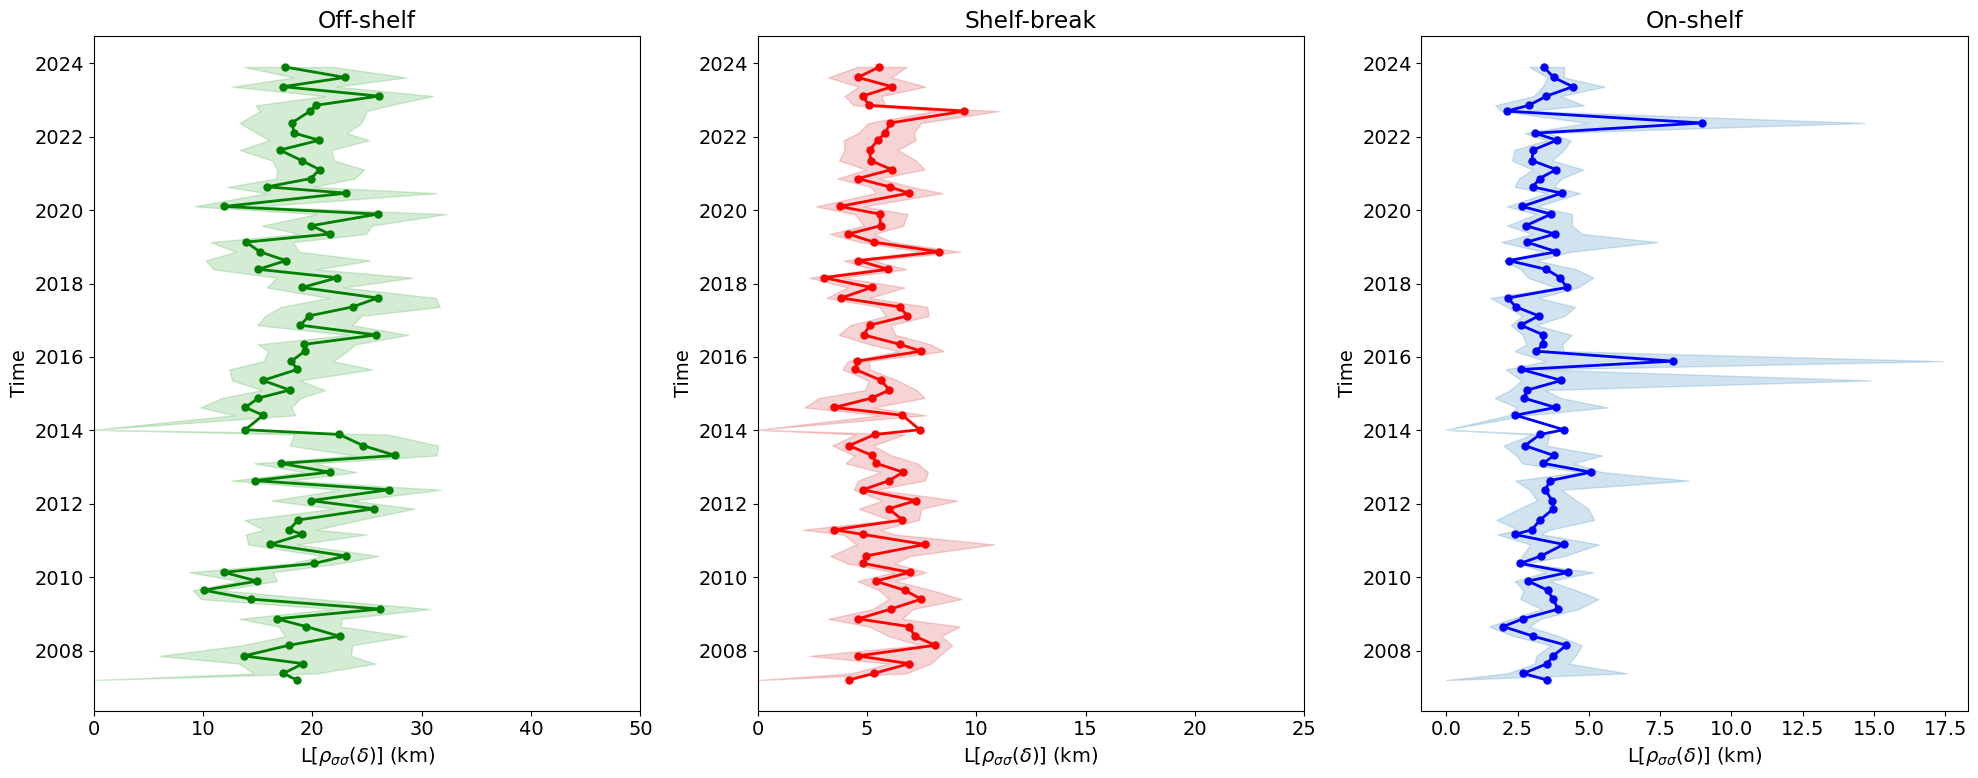

In [10]:
# Set the fontsize
plt.rcParams.update({'font.size': fontsize})

# Create the figure and 3D axis
fig = plt.figure(figsize=(20, 8))

#--- Subplot #1 ---# 
ax1 = fig.add_subplot(131)

# Plot the decorrelation length scale 
ax1.plot(L_off, time_season, 'g.-', linewidth=2, markersize=10)

# Plot the error bars of the mean autocorrelation function 
ax1.fill_betweenx(time_season,L_off_lstd,L_off_ustd,color='tab:green',alpha=0.2)

# Set figure attributes
ax1.set_title('Off-shelf')
ax1.set_xlabel('L[' + ylabel + '] (km)')
ax1.set_ylabel('Time')
ax1.set_xlim(0,50)

#--- Subplot #2 ---# 
ax2 = fig.add_subplot(132)

# Plot the decorrelation length scale 
ax2.plot(L_trans, time_season, 'r.-', linewidth=2, markersize=10)

# Plot the error bars of the mean autocorrelation function 
ax2.fill_betweenx(time_season,L_trans_lstd,L_trans_ustd,color='tab:red',alpha=0.2)

# Set figure attributes
ax2.set_title('Shelf-break')
ax2.set_xlabel('L[' + ylabel + '] (km)')
ax2.set_ylabel('Time')
ax2.set_xlim(0,25)

#--- Subplot #3 ---# 
ax3 = fig.add_subplot(133)

# Plot the decorrelation length scale 
ax3.plot(L_on, time_season, 'b.-', linewidth=2, markersize=10)

# Plot the error bars of the mean autocorrelation function 
ax3.fill_betweenx(time_season,L_on_lstd,L_on_ustd,color='tab:blue',alpha=0.2)

# Set figure attributes
ax3.set_title('On-shelf')
ax3.set_xlabel('L[' + ylabel + '] (km)')
ax3.set_ylabel('Time')

# Display figure
plt.tight_layout()
plt.show()

# Save figure 
fig.savefig(fname = PATH + '/figs/spray_glider/scale_analysis/decor_seasonal_' + option_var + '_depth_lim_' + str(depth_lim) + '_'  + years_d[0] + '_to_' + years_d[-1] + '_pcolor', bbox_inches = 'tight', dpi=300)
